In [ ]:
# Uncomment to install the required packages
# !pip install git+https://github.com/fagonzalezo/kdm.git

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import gaussian_kde

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import ModelCheckpoint


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from kdm.models import KDMDenEstModel, KDMClassModel, KDMJointDenEstModel
import kdm 

from tqdm import tqdm

import matplotlib.pyplot as plt

### 2.5.1 Discriminative training

The following example illustrates the use of the inference process with joint KDMs. We will use the two moons dataset. The model will be trained using discriminative learning using gradient descent.

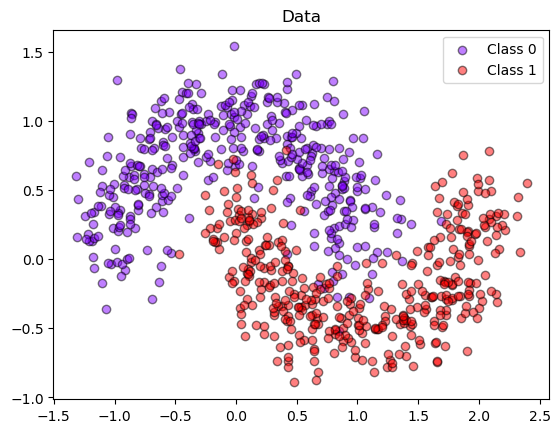

In [2]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

def gen_pred_fun_reg(clf):
    def pred_fun(X):
        return clf.predict(X)
    return pred_fun

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plot_data(X_train, y_train)

We use the KDMClassModel to train a shallow model that directly apply a KDM inference layer to the raw data. This class assumes a continuos distribution for the input data (i.e. it uses an RBF kernel) and a discrete distribution for the output data. The model is trained using gradient descent with a cross-entropy loss function.

In [5]:
encoded_size = 2
dim_y = 2
encoder = keras.layers.Identity()
n_comp = 30

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.05,
                            generative=1.)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=keras.losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
kdm_model.predict(X_train[:10])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=False)

kdm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.1886 - sparse_categorical_accuracy: 0.7459
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.1562 - sparse_categorical_accuracy: 0.9581
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8605 - sparse_categorical_accuracy: 0.9530
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7441 - sparse_categorical_accuracy: 0.9653
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7724 - sparse_categorical_accuracy: 0.9545
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6489 - sparse_categorical_accuracy: 0.9714
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7079 - sparse_categorical_accuracy: 0.9706
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6828 - sparse_categorical_accuracy: 0.9687
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.7282 - sparse_categorical_accuracy: 0.9573
Epoch 10/25
25/25 ━━━━━━

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test loss: 5.761058330535889
Test accuracy: 0.9750000238418579
Sigma: 0.2718598246574402


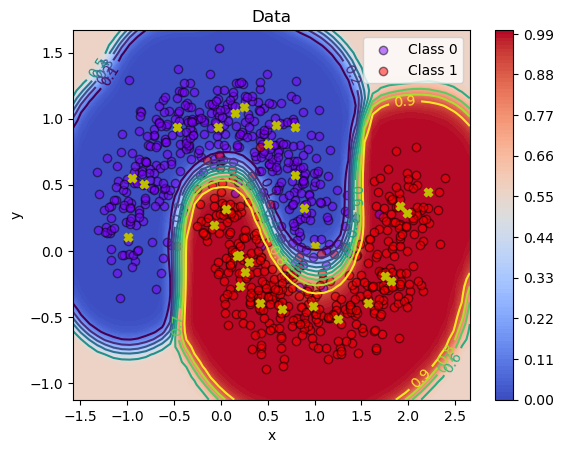

In [6]:
# Plot the decision region
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

The joint KDM components are shown as yellow crosses. Each component has two elements, an $x$ part and a $y$ part. The components are listed below:

In [7]:
weights = np.abs(kdm_model.kdm.c_w.numpy())
weights /= np.sum(weights)
idx = np.argsort(weights)[::-1]
for i in range(kdm_model.n_comp):
    print(f'Component {i}')
    print(f' Weight: {weights[idx[i]]}')
    print(f' x: {kdm_model.kdm.c_x[idx[i]].numpy()}')
    print(f' y: {kdm_model.kdm.c_y[idx[i]].numpy()}')


Component 0
 Weight: 0.09205885976552963
 x: [-0.466114  0.9362  ]
 y: [1. 0.]
Component 1
 Weight: 0.06728612631559372
 x: [ 0.64828205 -0.4427204 ]
 y: [0. 1.]
Component 2
 Weight: 0.06520844250917435
 x: [-0.8198129  0.5090455]
 y: [1. 0.]
Component 3
 Weight: 0.055532388389110565
 x: [ 1.7521938  -0.19332588]
 y: [0. 1.]
Component 4
 Weight: 0.05486001819372177
 x: [0.79166365 0.5711187 ]
 y: [1. 0.]
Component 5
 Weight: 0.05323369801044464
 x: [0.05907832 0.3179737 ]
 y: [0. 1.]
Component 6
 Weight: 0.05112515762448311
 x: [-0.030344    0.93437654]
 y: [1. 0.]
Component 7
 Weight: 0.049585092812776566
 x: [0.50561714 0.8117182 ]
 y: [1. 0.]
Component 8
 Weight: 0.04947518929839134
 x: [-0.98773235  0.10452836]
 y: [1. 0.]
Component 9
 Weight: 0.04625323414802551
 x: [1.9814253  0.28231135]
 y: [0. 1.]
Component 10
 Weight: 0.046039171516895294
 x: [ 1.2541883 -0.515001 ]
 y: [0. 1.]
Component 11
 Weight: 0.03759542480111122
 x: [ 1.5694749  -0.39523232]
 y: [0. 1.]
Component 12
 W

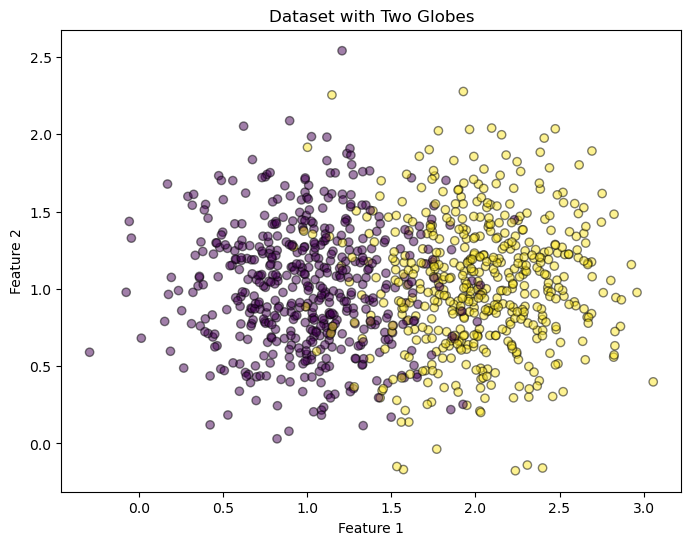

array([[0.1, 0.9],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

In [23]:
from sklearn.datasets import make_blobs

# Create a dataset with two blobs located at (1, 1) and (2, 1)
centers = [(1, 1), (2, 1)]
X_blobs, y_blobs = make_blobs(n_samples=1000, centers=centers, cluster_std=0.4, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis', alpha=0.5, edgecolor='k')
plt.title("Dataset with Two Globes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

y_blobs_ohe = keras.utils.to_categorical(y_blobs)
# scale y_blobs to be in the range [0.1, 0.9]
y_blobs = (y_blobs - np.min(y_blobs)) / (np.max(y_blobs) - np.min(y_blobs)) * 0.8 + 0.1
y_blobs_ohe = (y_blobs_ohe - np.min(y_blobs_ohe)) / (np.max(y_blobs_ohe) - np.min(y_blobs_ohe)) * 0.8 + 0.1

y_blobs_ohe[0:10]


In [44]:
encoded_size = 2
dim_y = 2
encoder = keras.layers.Identity()
n_comp = 30

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1,
                            sigma_trainable=False,
                            generative=1.)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=keras.losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
#kdm_model.predict(X_train[:10])
idx = np.random.randint(X_blobs.shape[0], size=n_comp)
kdm_model.init_components(X_blobs[idx], 
                          y_blobs_ohe[idx],
                          init_sigma=False)

kdm_model.fit(X_blobs, y_blobs_ohe, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - categorical_accuracy: 0.8483 - loss: 8.0608
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.8841 - loss: 7.0095
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.8793 - loss: 7.0124
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8775 - loss: 6.8717
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.8974 - loss: 6.7503
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.8736 - loss: 6.8083
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8947 - loss: 6.5984
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8899 - loss: 6.4789
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8977 - loss: 6.5025
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8889 - loss: 6.6391


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test loss: 6.530935287475586
Test accuracy: 0.8920000195503235
Sigma: 0.10000000149011612


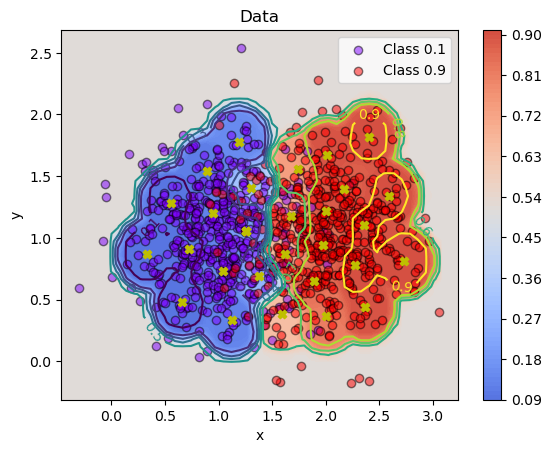

In [45]:
# Plot the decision region
plot_decision_region(X_blobs, gen_pred_fun(kdm_model))
plot_data(X_blobs, y_blobs)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_blobs, y_blobs_ohe, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

In [46]:
weights = np.abs(kdm_model.kdm.c_w.numpy())
weights /= np.sum(weights)
idx = np.argsort(weights)[::-1]
for i in range(kdm_model.n_comp):
    print(f'Component {i}')
    print(f' Weight: {weights[idx[i]]}')
    print(f' x: {kdm_model.kdm.c_x[idx[i]].numpy()}')
    v = kdm_model.kdm.c_y[idx[i]].numpy()
    v = keras.utils.normalize(v, order=2, axis=-1)
    print(f' y: {v ** 2}')


Component 0
 Weight: 0.07161734253168106
 x: [1.037316  0.7300374]
 y: [[0.85765177 0.14234836]]
Component 1
 Weight: 0.059730224311351776
 x: [0.947222  1.2019181]
 y: [[0.8740111 0.1259889]]
Component 2
 Weight: 0.05767083168029785
 x: [1.975833  0.9392136]
 y: [[0.16849402 0.8315059 ]]
Component 3
 Weight: 0.05005186051130295
 x: [1.6748694 1.1741855]
 y: [[0.32761103 0.672389  ]]
Component 4
 Weight: 0.047253888100385666
 x: [0.72409874 0.911472  ]
 y: [[0.90206945 0.09793053]]
Component 5
 Weight: 0.04506584256887436
 x: [2.3533468 1.1007744]
 y: [[0.09966589 0.9003341 ]]
Component 6
 Weight: 0.0436677411198616
 x: [1.8884526  0.64758366]
 y: [[0.15649706 0.8435029 ]]
Component 7
 Weight: 0.040561020374298096
 x: [1.615319   0.86794144]
 y: [[0.323313   0.67668694]]
Component 8
 Weight: 0.040152858942747116
 x: [0.55977166 1.2843148 ]
 y: [[0.90617317 0.09382685]]
Component 9
 Weight: 0.03854409605264664
 x: [2.0063639 1.2162098]
 y: [[0.11080705 0.88919306]]
Component 10
 Weight:

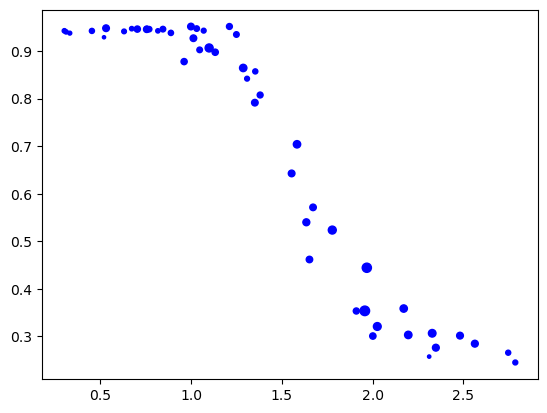

In [43]:
ys  = kdm_model.kdm.c_y.numpy()
ys = keras.utils.normalize(ys, order=2, axis=-1)
xs = kdm_model.kdm.c_x.numpy()[:, 0]
# plot the prototypes with circles with size proportional to the weights
plt.scatter(xs, ys[:, 0], c='b', marker='o', s=weights*1000)
